In [79]:
from argparse import ArgumentParser
from sklearn.preprocessing import SplineTransformer
from collections import OrderedDict
from torch import nn
import torch
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
import os

def sim_data(n, dim, Type):
    if Type == 'A':
        X = torch.rand((n,dim))
        y = torch.exp(2*torch.sin(X[:,0]*0.5*torch.pi)+ 0.5*torch.cos(X[:,1]*2.5*torch.pi))
        y = y.reshape(-1,1)
        y = y.float()

    elif Type == 'B':
        X = torch.rand((n, dim))
        y = 1
        for d in range(dim):
            a = (d+1)/2
            y *= ((torch.abs(4*X[:,d]-2)+a)/(1+a))
        y = y.reshape(-1,1)
        y = y.float()
    else:
        pass

    return X, y

def norm(x):
    return (x-torch.min(x))/(torch.max(x)-torch.min(x))

def diag_mat_weights(dimp, type = 'first'):
    if type == 'first':
        dg = np.zeros((dimp-1, dimp))
        for i in range(dimp-1):
            dg[i,i] = -1
            dg[i,i+1]= 1
    elif type == 'second':
        dg = np.zeros((dimp-2, dimp))
        for i in range(dimp-2):
            dg[i,i] = -1
            dg[i,i+1]= 2
            dg[i,i+2]= -1
    else:
        pass
    return torch.Tensor(dg)

def num_para(model):
    tp = 0
    for param in model.parameters():
        tp += param.numel()
    return tp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## ECM

In [4]:
def ECM(par, initial_xi = 1, initial_sigma = 1, initial_lambda = 1e-4):
    lambdab = initial_lambda
    sigma = initial_sigma
    xi = initial_xi
    
    n_block, num_knots, num_neurons = par['wbasic'].size()
    ls_lambda = torch.empty(n_block)
    
    for l in range(n_block):
        B = par['ebasic'][l]
        By = par['basic'][l]
        WB = par['wbasic'][l]
        
        DB = diag_mat_weights(WB.size()[0]).to(device)
        size = B.size()[1]
        S = DB.T @ DB
        Cov_a = (xi**2)* torch.linalg.pinv(S)
        Cov_a.to(device)
        Cov_e = (torch.eye(size*num_neurons)* sigma).to(device)
        
        block_y = torch.reshape(By, (-1,1))
        flatB = B.view(num_neurons, num_knots, size)
            
        sqr_xi= 0
        sqr_sig = 0

        for i in range(num_neurons):
            Ncov = (Cov_a -(Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)]) @ flatB[i].T @ Cov_a))
            Nmu = (Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)])) @ By[:,i].reshape(-1,1)
            
            first_xi = S @ Ncov
            second_xi = (Nmu.T @ S @ Nmu)
            sqr_xi += torch.trace(first_xi) + second_xi
                
            first_sig = torch.norm(By[:,i])
            second_sig = 2 * (By[:,i] @ flatB[i].T) @ Nmu 
            third_sig = torch.trace((flatB[i] @ flatB[i].T) @ Ncov)
            four_sig = (Nmu.T @ flatB[i] @ flatB[i].T @ Nmu)
            
            sqr_sig += (first_sig + second_sig + third_sig + four_sig)
            
            del first_xi, second_xi, first_sig, second_sig, third_sig, four_sig

        sqr_xi /= num_neurons
        sqr_sig /= (num_neurons*size)

        ls_lambda[l] = (sqr_sig/sqr_xi).item()
        
        del Cov_a, Cov_e, flatB
    
    return ls_lambda
    
def ECM_layersise_update(model, par, Lambda, x, y):

    model.eval()
    '''
    with torch.no_grad():
        DSy = model(x)
        print('Training Error: ', np.round(criterion(y, DSy.detach()).item(), 5))
    '''
    
    device = x.device
    
    B_out, B_in, B_w, B_b = par['basic'], par['ebasic'], par['wbasic'], par['bbasic']
    n_layer, nk, nm = B_w.size()
    DB = diag_mat_weights(B_w[0].size()[0], 'second').to(device)

    Project_matrix = (torch.linalg.pinv(B_in[-1].T @ B_in[-1]) @ B_in[-1].T @ B_in[-1])
    Size = [b.size()[1] for b in B_in]

    B_in = B_in.view(n_layer, nm, nk, Size[0])
    
    for l in range(n_layer):    
        NW = torch.empty((nk, nm)).to(device)
        NB = torch.empty((nm)).to(device)
        
        for i in range(nm):
            B1y = B_out[l][:,i] - B_b[l][i]
            BB = B_in[l][i].T
    
            # Update the weights and bias
            NW[:, i] = (torch.inverse(BB.T @ BB + (Lambda[l]/Size[l]) * (DB.T @ DB)) @ BB.T @ B1y)
            NB[i] = torch.mean(B_out[l][:,i] - (NW[:,i] @ BB.T))
                
        # update the weight
        block = getattr(model.Spline_block.model, f'block_{l}')
        getattr(block.block.BSL, 'control_p').data = NW
        getattr(block.block.BSL, 'bias').data = NB

    
    with torch.no_grad():
        DPSy = model(x)
        Update_Train_Loss = np.round(criterion(y, DPSy.detach()).item(), 5)
        GCV = np.round((torch.norm(y - DPSy)/(Size[-1]-torch.trace(Project_matrix))).item(), 5)
    
    return model, GCV

def ECM_update(model, max_iter, x, y):
    BestGCV = 9999
    patient = 5
    pcount = 0
    for i in range(max_iter):
        _ = model(X_train)
        ECM_para = model.get_para_ecm(x)
        ECM_Lambda = ECM(ECM_para, initial_xi = 1, initial_sigma = 1, initial_lambda = 1e-4)

        print('Lambda: ', ECM_Lambda)
        model, GCV = ECM_layersise_update(model, ECM_para, ECM_Lambda, x, y)

        if GCV < BestGCV:
            BestLambda = ECM_Lambda
            BestGCV = GCV
            pcount = 0
        else:
            pcount += 1

        if pcount == patient:
            break

        del ECM_para, ECM_Lambda
    
    return BestLambda

## Model

In [26]:
class BSL(nn.Module):
    def __init__(self, degree, num_knots, num_neurons, bias = True):
        super(BSL, self).__init__()
        self.degree = degree
        self.num_knots = num_knots
        self.num_neurons = num_neurons
        self.control_p = nn.Parameter(torch.randn(self.num_knots, self.num_neurons))
        
        if bias:
            self.bias = nn.Parameter(torch.randn(self.num_neurons))
        else:
            self.register_parameter('bias', None)
            
        self.inter = {}
    
    def basis_function(self, x, i, k, t):
    
        # Base case: degree 0 spline
        if k == 0:
            return ((t[i] <= x) & (x < t[i + 1])).float()
    
        # Recursive case
        denom1 = t[i + k] - t[i]
        denom2 = t[i + k + 1] - t[i + 1]
    
        term1 = 0
        if denom1 != 0:
            term1 = (x - t[i]) / denom1 * self.basis_function(x, i, k - 1, t)
    
        term2 = 0
        if denom2 != 0:
            term2 = (t[i + k + 1] - x) / denom2 * self.basis_function(x, i + 1, k - 1, t)
    
        return term1 + term2

    def knots_distribution(self, dg, nk):

        knots = torch.cat([torch.linspace(-0.002, -0.001, steps=dg),            # Add repeated values at the start for clamping
            torch.linspace(0, 1, nk-2*dg-2),  # Uniform knot spacing in the middle
            torch.linspace(1.001, 1.002, steps=dg)           # Add repeated values at the end for clamping
            ]).view(-1,1)
     
        return knots
    
    def basis_function2(self, x, spl):
        basis_output = spl.fit_transform(x.cpu().numpy())
        return basis_output
            
    def forward(self, x):
        batch_size, num_features = x.size()
        device = x.device
        
        # Create knot vector and apply B-spline basis functions for each feature

        '''
        knots = torch.cat([
                        torch.zeros(self.degree),               # Add repeated values at the start for clamping
                        torch.linspace(0, 1, self.num_knots - self.degree + 1),  # Uniform knot spacing in the middle
                        torch.ones(self.degree)                 # Add repeated values at the end for clamping
                    ]).to(device)

        # Apply B-spline basis functions for each feature

        basises = []
        
        
        for feature in range(num_features):
            # Calculate B-spline basis functions for this feature
            basis = torch.stack([self.basis_function(x[:, feature], i, self.degree, knots) 
                                 for i in range(self.num_knots)], dim=-1)
            basises.append(basis)
            
        '''
    
        basises = []
        knots = self.knots_distribution(self.degree, self.num_knots)
        #knots = knots.to(device)
        spl = SplineTransformer(n_knots=self.num_knots, degree=self.degree, knots = knots)

        
        for feature in range(num_features):
            # Calculate B-spline basis functions for this feature
            
            basis = self.basis_function2(x[:, feature].reshape(-1,1), spl)
            basis = torch.Tensor(basis).to(device)
            basises.append(basis)
        
        
        if num_features == 1:
            tout = basises[0] @ self.control_p
            self.inter['basic'] = basises[0].T
        else:
            self.inter['basic'] = torch.reshape(torch.stack(basises, dim = 1), (batch_size, self.num_knots * self.num_neurons)).T
            basises = torch.stack(basises)
            tout = basises.permute(1,2,0) * self.control_p
            tout = tout.sum(dim =1)
                
        if self.bias is not None:
            tout += self.bias        
            
        return tout


class NormLayer(nn.Module):
    def __init__(self):
        super(NormLayer, self).__init__()

    def forward(self, x):
        min_val = torch.min(x, axis = 1).values.reshape(-1,1)
        max_val = torch.max(x, axis = 1).values.reshape(-1,1)

        x = (x - min_val)/(max_val - min_val)  # Rescale to [0, 1]
        return x.detach()

In [27]:
class BSpline_block(nn.Module):
    def __init__(self, degree, num_knots, num_neurons, dropout = 0.0, bias = True):
        super(BSpline_block, self).__init__()

        self.block = nn.Sequential(OrderedDict([
            ('norm', NormLayer()),
            ('BSL', BSL(degree = degree, num_knots = num_knots, num_neurons = num_neurons, bias = bias)),
            ('drop', nn.Dropout(dropout)),
        ]))
        
    def forward(self, x):
        return self.block(x)
        
class StackBS_block(nn.Module):
    def __init__(self, block, degree, num_knots, num_neurons, num_blocks, dropout = 0.0, bias = True):
        super().__init__()
        self.model = nn.ModuleDict({
            f'block_{i}': block(degree = degree, num_knots = num_knots, num_neurons = num_neurons)
            for i in range(num_blocks)
        })

    def forward(self, x):
        for name, block in self.model.items():
            x = block(x)
        return x

In [112]:

class DPS(nn.Module):
    def __init__(self, input_dim, degree, num_knots, num_neurons, num_bsl, dropout, output_dim, bias):
        super(DPS, self).__init__()
        self.num_neurons = num_neurons
        self.num_knots = num_knots
        self.ln1 = nn.Linear(input_dim, num_neurons)
        #self.nm1 = NormLayer() 
        #self.sp1 = BSL(degree = degree, num_knots = num_knots, num_neurons = num_neurons, bias = True)
        self.Spline_block = StackBS_block(BSpline_block, degree = degree, num_knots = num_knots, num_neurons = num_neurons, num_blocks = num_bsl, dropout = dropout)
        self.ln2 = nn.Linear(num_neurons, output_dim)
        #self.inter = {}
        
    def forward(self, x):
        
        x = self.ln1(x)
        spout = self.Spline_block(x)
        output = self.ln2(spout)
        
        return output

    def get_para_ecm(self, x):

        '''
        ecm_para: A dictionary that collects the parameter we need to the following ECM algorithm.
        ecm_para.basic: Store the output of each B-Spline block; Dimension = [n_sample, n_neurons]
        ecm_para.ebasic Store the weight matrix of each B-Spline expansion; Dimension = [n_knots * n_neurons, n_sample]

        '''
        ecm_para = {}
        bs_block_out = {}
        bs_spline_weight = {}
        bs_spline_value = {}
        bs_spline_bias = {}

        _ = self(x)
        
        def get_activation(name):
            def hook(model, input, output):
                bs_block_out[name] = output.detach()
            return hook

        handles = []
        for name, layer in self.named_modules():
            if 'block.drop' in name:
                handles.append(layer.register_forward_hook(get_activation(name)))
            elif 'block.BSL' in name:
                bs_spline_value[name] = layer.inter['basic'].detach()
                bs_spline_weight[name] = layer.control_p.detach()
                bs_spline_bias[name] = layer.bias.detach()
        # Run forward pass (triggers hooks)
        _ = self(x)

        # Clean up hooks
        for h in handles:
            h.remove()
            
        ecm_para['basic'] = torch.stack(list(bs_block_out.values()), dim=0)
        ecm_para['ebasic'] = torch.stack(list(bs_spline_value.values()), dim=0)
        ecm_para['wbasic'] = torch.stack(list(bs_spline_weight.values()), dim=0)
        ecm_para['bbasic'] = torch.stack(list(bs_spline_bias.values()), dim=0)
        del bs_block_out, bs_spline_weight, bs_spline_value, bs_spline_bias
        
        return ecm_para

    def fit(self, x):
        return 0

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss  # because we want to minimize val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        
def train_one_epoch(model, x, y, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    x, y = x.to(device), y.to(device)

    optimizer.zero_grad()
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    return loss

                
def validate(model, x, y, criterion, device):
    model.eval()
    total_loss = 0.0
    x, y = x.to(device), y.to(device)
    outputs = model(x)
    loss = criterion(outputs, y)

    return loss

## Data Preprocessing

In [187]:
ntrain = 800; nval = 100; ntest = 500; ndim = 30; ndf = 1
Dtype = 'A'
data = {}
device = torch.device("mps:0" if torch.mps.is_available() else "cpu")
torch.manual_seed(0)

for d in range(ndf):
    X_train, y_train = sim_data(ntrain, ndim, Dtype)
    X_train, y_train = X_train.to(device), y_train.to(device) 
    X_val, y_val = sim_data(nval, ndim, Dtype)
    X_val, y_val = X_val.to(device), y_val.to(device) 
    X_test, y_test = sim_data(ntest, ndim, Dtype)
    X_test, y_test = X_test.to(device), y_test.to(device) 
    
    epstrain = torch.normal(0, torch.var(y_train)*0.01, size=y_train.size()).to(device) 
    epsval = torch.normal(0, torch.var(y_val)*0.01, size=y_val.size()).to(device) 
    epstest = torch.normal(0, torch.var(y_test)*0.01, size=y_test.size()).to(device) 
    
    y_train, y_val, y_test = y_train + epstrain, y_val + epsval, y_test + epstest
    data[str(d+1)] = {'TrainX': X_train, 'Trainy': y_train, 'ValX': X_val, 'Valy': y_val, 'TestX': X_test, 'Testy': y_test}
    
    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    criterion = torch.nn.MSELoss(reduction='mean')

## Training

In [188]:
## Model Setting
dg = 3; nk = 15; nm = 50; Fout = 1; nl = 2
DeepBS = DPS(input_dim = ndim, degree = dg, num_knots = nk, num_neurons = nm, num_bsl = nl, dropout = 0.0, output_dim = Fout, bias = True).to(device)
learning_r = 1e-1
optimizer = torch.optim.Adam(DeepBS.parameters(), lr=learning_r)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
best_model_path = "best_DBS_model.pt"
early_stopping = EarlyStopping(patience=30, verbose=True, delta=1e-3, path= best_model_path)
epochs = 10000

In [189]:
for epoch in range(epochs):
    # Forward pass: Compute predicted y by passing x to the modelsp
    train_loss = train_one_epoch(DeepBS, X_train, y_train, criterion, optimizer, device)
    val_loss = validate(DeepBS, X_train, y_train, criterion, device)
    
    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | " f"Val Loss: {val_loss:.4f}")
    scheduler.step()
    early_stopping(val_loss, DeepBS)

    if early_stopping.early_stop:
        print("Early stopping triggered. Restoring best model...")        
        break

Epoch 01 | Train Loss: 38.5332 | Val Loss: 8.6581
Validation loss decreased (inf --> 8.658144). Saving model ...
Epoch 02 | Train Loss: 8.6581 | Val Loss: 21.1646
EarlyStopping counter: 1 out of 30
Epoch 03 | Train Loss: 21.1646 | Val Loss: 15.9467
EarlyStopping counter: 2 out of 30
Epoch 04 | Train Loss: 15.9467 | Val Loss: 8.8207
EarlyStopping counter: 3 out of 30
Epoch 05 | Train Loss: 8.8207 | Val Loss: 11.8043
EarlyStopping counter: 4 out of 30
Epoch 06 | Train Loss: 11.8043 | Val Loss: 15.1092
EarlyStopping counter: 5 out of 30
Epoch 07 | Train Loss: 15.1092 | Val Loss: 12.7490
EarlyStopping counter: 6 out of 30
Epoch 08 | Train Loss: 12.7490 | Val Loss: 9.1941
EarlyStopping counter: 7 out of 30
Epoch 09 | Train Loss: 9.1941 | Val Loss: 8.2553
Validation loss decreased (8.658144 --> 8.255270). Saving model ...
Epoch 10 | Train Loss: 8.2553 | Val Loss: 9.7608
EarlyStopping counter: 1 out of 30
Epoch 11 | Train Loss: 9.7608 | Val Loss: 10.3266
EarlyStopping counter: 2 out of 30
Epo

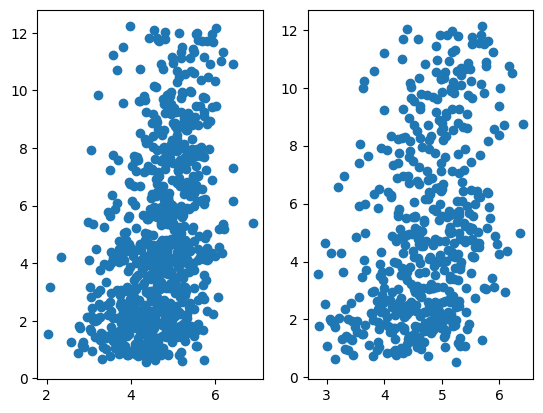

In [190]:
with torch.no_grad():
    pyb_af = DeepBS(X_train)
    plt.subplot(121)
    plt.scatter(pyb_af.cpu().detach().numpy(), y_train.cpu().detach().numpy())
    pyb_af = DeepBS(X_test)
    plt.subplot(122)
    plt.scatter(pyb_af.cpu().detach().numpy(), y_test.cpu().detach().numpy())

tensor(7.4353, device='mps:0')
tensor(8.5787, device='mps:0')


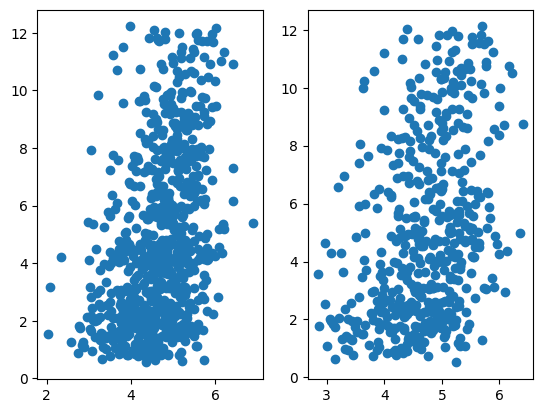

In [191]:
model = DPS(input_dim = ndim, degree = dg, num_knots = nk, num_neurons = nm, num_bsl = nl, dropout = 0.0, output_dim = Fout, bias = True).to(device)
model.load_state_dict(torch.load('./best_DBS_model.pt', weights_only = True))

with torch.no_grad():
    pyb_af = model(X_train)
    print(criterion(y_train, pyb_af))
    plt.subplot(121)
    plt.scatter(pyb_af.cpu().detach().numpy(), y_train.cpu().detach().numpy())
    pyb_af = model(X_test)
    plt.subplot(122)
    print(criterion(y_test, pyb_af))
    plt.scatter(pyb_af.cpu().detach().numpy(), y_test.cpu().detach().numpy())
    

## ECM-Fine Tuning

In [192]:
def ECM(par, initial_xi = 1, initial_sigma = 1, initial_lambda = 1e-4):
    lambdab = initial_lambda
    sigma = initial_sigma
    xi = initial_xi
    
    n_block, num_knots, num_neurons = par['wbasic'].size()
    ls_lambda = torch.empty(n_block)
    
    for l in range(n_block):
        B = par['ebasic'][l]
        By = par['basic'][l]
        WB = par['wbasic'][l]
        
        DB = diag_mat_weights(WB.size()[0]).to(device)
        size = B.size()[1]
        S = DB.T @ DB
        Cov_a = (xi**2)* torch.linalg.pinv(S)
        Cov_a.to(device)
        Cov_e = (torch.eye(size*num_neurons)* sigma).to(device)
        
        block_y = torch.reshape(By, (-1,1))
        flatB = B.view(num_neurons, num_knots, size)
            
        sqr_xi= 0
        sqr_sig = 0

        for i in range(num_neurons):
            Ncov = (Cov_a -(Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)]) @ flatB[i].T @ Cov_a))
            Nmu = (Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)])) @ By[:,i].reshape(-1,1)
            
            first_xi = S @ Ncov
            second_xi = (Nmu.T @ S @ Nmu)
            sqr_xi += torch.trace(first_xi) + second_xi
                
            first_sig = torch.norm(By[:,i])
            second_sig = 2 * (By[:,i] @ flatB[i].T) @ Nmu 
            third_sig = torch.trace((flatB[i] @ flatB[i].T) @ Ncov)
            four_sig = (Nmu.T @ flatB[i] @ flatB[i].T @ Nmu)
            
            sqr_sig += (first_sig + second_sig + third_sig + four_sig)

            del Ncov, Nmu
            del first_xi, second_xi, first_sig, second_sig, third_sig, four_sig

        sqr_xi /= num_neurons
        sqr_sig /= (num_neurons*size)

        ls_lambda[l] = (sqr_sig/sqr_xi).item()
        
        del Cov_a, Cov_e, flatB
    
    return ls_lambda

### Via ECM to implement layer-wise optimization for tuning the weight for B-Spline Block

In [193]:
model = DPS(input_dim = ndim, degree = dg, num_knots = nk, num_neurons = nm, num_bsl = nl, dropout = 0.0, output_dim = Fout, bias = True).to(device)
model.load_state_dict(torch.load('./best_DBS_model.pt', weights_only = True))

BestLambda = ECM_update(model, 10, X_train, y_train)

Lambda:  tensor([0.2051, 0.1823])
Lambda:  tensor([0.2051, 0.1823])
Lambda:  tensor([0.2052, 0.1823])
Lambda:  tensor([0.2052, 0.1823])
Lambda:  tensor([0.2052, 0.1824])
Lambda:  tensor([0.2052, 0.1824])


### Fast-Tuning for optimimal DPS parameter

In [195]:
DeepPS = DPS(input_dim = ndim, degree = dg, num_knots = nk, num_neurons = nm, num_bsl = nl, dropout = 0.0, output_dim = Fout, bias = True).to(device)
DeepPS.load_state_dict(torch.load('./best_DBS_model.pt', weights_only = True))

learning_r = 1e-2
optimizer = torch.optim.Adam(DeepPS.parameters(), lr=learning_r)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
best_model_path = "best_DPS_model.pt"
early_stopping = EarlyStopping(patience=30, verbose=True, delta=1e-3, path= best_model_path)
Fast_tun_epoch = 1001

for epoch in range(Fast_tun_epoch):
    # Forward pass: Compute predicted y by passing x to the modelsp
    train_loss = train_one_epoch(DeepPS, X_train, y_train, criterion, optimizer, device)
    val_loss = validate(DeepPS, X_train, y_train, criterion, device)

    if epoch % 10 == 0:
        print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | " f"Val Loss: {val_loss:.4f}")
        
    scheduler.step()
    early_stopping(val_loss, DeepPS)

    if early_stopping.early_stop:
        print("Early stopping triggered. Restoring best model...")        
        break

Epoch 01 | Train Loss: 7.4353 | Val Loss: 7.4149
Validation loss decreased (inf --> 7.414865). Saving model ...
Validation loss decreased (7.414865 --> 7.360734). Saving model ...
Validation loss decreased (7.360734 --> 7.342570). Saving model ...
Validation loss decreased (7.342570 --> 7.293465). Saving model ...
Validation loss decreased (7.293465 --> 7.266087). Saving model ...
Validation loss decreased (7.266087 --> 7.245135). Saving model ...
Validation loss decreased (7.245135 --> 7.208328). Saving model ...
Validation loss decreased (7.208328 --> 7.176272). Saving model ...
Validation loss decreased (7.176272 --> 7.155724). Saving model ...
Validation loss decreased (7.155724 --> 7.129888). Saving model ...
Epoch 11 | Train Loss: 7.1299 | Val Loss: 7.1134
Validation loss decreased (7.129888 --> 7.113428). Saving model ...
Validation loss decreased (7.113428 --> 7.097744). Saving model ...
Validation loss decreased (7.097744 --> 7.085620). Saving model ...
Validation loss decreas

## Evaluation on DS and DPS

In [140]:
Fast_tun_epoch = 1001
for d in range(ndf):
    print('Dataset '+str(d+1))
    DeepPS = DPS(input_dim = ndim, degree = 3, num_knots = nk, num_neurons = nm, num_bsl = 2, output_dim = Fout, bias = True).to(device)
    DeepPS.load_state_dict(torch.load( './EXA'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk)+'data'+str(d+1), weights_only = True))
    optimizer = torch.optim.Adam(DeepPS.parameters(), lr= 1e-2)
    n = X_train.size()[0]

    ## Access to the Weight matrix for spline
    DPS_Wstack = []
    for l in range(nl):    
        block = getattr(model.Spline_block.model, f'block_{l}')
        DPS_Wstack.append(getattr(block.block.BSL, 'control_p').data)

    for t in range(1, Fast_tun_epoch):

        # Forward pass: Compute predicted y by passing x to the modelsp
        pyb_af = DeepPS(X_train)
        loss = criterion(y_train, pyb_af)

        for l in range(nl):
            loss += (BestLambda[l]/n * torch.norm(diag_mat_weights(DPS_Wstack[l].size()[0]).to(device) @ DPS_Wstack[l]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    with torch.no_grad():
        PMSPE = criterion(y_test, DeepPS(X_test).detach()).item()
        Pres[d] = PMSPE

Dataset 1


TypeError: DPS.__init__() missing 1 required positional argument: 'dropout'

## MLP

In [197]:
class FlexibleMLP(nn.Module):
    def __init__(self, layer_sizes, activation_fn=nn.ReLU, output_activation=None):
        """
        layer_sizes: list of integers specifying sizes of each layer including input and output
        activation_fn: activation function class to apply between layers (e.g., nn.ReLU)
        output_activation: optional activation function class for output layer (e.g., nn.Softmax)
        """
        super(FlexibleMLP, self).__init__()

        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:
                layers.append(activation_fn())
            elif output_activation is not None:
                layers.append(output_activation())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

nneuron = 100
model = FlexibleMLP([ndim, nneuron, nneuron, nneuron, nneuron, 1], activation_fn=nn.ReLU, output_activation = None).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion = torch.nn.MSELoss(reduction='mean')
best_model_path = "best_DNN_model.pt"
early_stopping = EarlyStopping(patience=30, verbose=True, delta=1e-3, path= best_model_path)

for epoch in range(epochs):
    # Forward pass: Compute predicted y by passing x to the modelsp
    train_loss = train_one_epoch(model, X_train, y_train, criterion, optimizer, device)
    val_loss = validate(model, X_train, y_train, criterion, device)
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | " f"Val Loss: {val_loss:.4f}")
        
    scheduler.step()
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping triggered. Restoring best model...")        
        break

Epoch 01 | Train Loss: 29.8181 | Val Loss: 27.8531
Validation loss decreased (inf --> 27.853081). Saving model ...
Validation loss decreased (27.853081 --> 22.104801). Saving model ...
Validation loss decreased (22.104801 --> 10.546628). Saving model ...
EarlyStopping counter: 1 out of 30
Validation loss decreased (10.546628 --> 9.206956). Saving model ...
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
EarlyStopping counter: 3 out of 30
EarlyStopping counter: 4 out of 30
EarlyStopping counter: 5 out of 30
Epoch 11 | Train Loss: 18.7869 | Val Loss: 18.4597
EarlyStopping counter: 6 out of 30
EarlyStopping counter: 7 out of 30
EarlyStopping counter: 8 out of 30
EarlyStopping counter: 9 out of 30
EarlyStopping counter: 10 out of 30
EarlyStopping counter: 11 out of 30
EarlyStopping counter: 12 out of 30
Validation loss decreased (9.206956 --> 8.116271). Saving model ...
Validation loss decreased (8.116271 --> 7.996550). Saving model ...
EarlyStopping counter: 1 out of

In [198]:
with torch.no_grad():
    pyb_af = DeepPS(X_test)
    print(criterion(y_test, pyb_af))
    pyb_af = model(X_test)
    print(criterion(y_test, pyb_af))    

tensor(8.0464, device='mps:0')
tensor(8.5047, device='mps:0')
